In [1]:
from __future__ import division, print_function
import sys, os, glob, gc, warnings
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import matplotlib.pyplot as plt

from desitarget.targets import desi_mask

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
ramin, ramax = 260, 268
decmin, decmax = 11, 18

In [4]:
sweep_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0'
resid_dir = '/global/cscratch1/sd/rongpu/desi/dr8_sweep_apflux_resid/south'

columns = ['TYPE', 'RA', 'DEC', 'EBV', 
          'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 
          'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 
          'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 
          'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 
          'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 
          'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 
          'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2',
          'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
          'MASKBITS']

# Identify the corresponding sweep files
sweep_path_all = glob.glob(os.path.join(sweep_dir, '*.fits'))
sweep_fn_all = [os.path.basename(sweep_path_all[ii]) for ii in range(len(sweep_path_all))]
sweep_fn_list = []
for index in range(len(sweep_fn_all)):
    brick = sweep_fn_all[index][-20:-5]
    ra1min, ra1max = float(brick[0:3]), float(brick[8:11])
    dec1min = float(brick[4:7]) if brick[3]=='p' else -float(brick[4:7])
    dec1max = float(brick[-3:]) if brick[-4]=='p' else -float(brick[-3:])
    if (((ramin>=ra1min) & (ramin<ra1max)) | ((ramax>ra1min) & (ramax<=ra1max))) \
         & (((decmin>=dec1min) & (decmin<dec1max)) | ((decmax>dec1min) & (decmax<=dec1max))):
        sweep_fn_list.append(sweep_fn_all[index])
print(sweep_fn_list)

# Load sweep data and residual aperture fluxes
tmp_stack = []
for sweep_index in range(len(sweep_fn_list)):
    sweep_fn = sweep_fn_list[sweep_index]
    tmp = fitsio.read(os.path.join(sweep_dir, sweep_fn), columns=columns)
    tmp = Table(tmp)
    tmp1 = fitsio.read(os.path.join(resid_dir, sweep_fn[:-5]+'-resid.fits'))
    tmp1 = Table(tmp1)
    tmp = hstack([tmp, tmp1])
    
    mask = (tmp['RA']>ramin) & (tmp['RA']<ramax) & (tmp['DEC']>decmin) & (tmp['DEC']<decmax)
    # Requiring 2+ exposures in each band
    mask &= (tmp['NOBS_G']>=2) & (tmp['NOBS_R']>=2) & (tmp['NOBS_Z']>=2)
    tmp = tmp[mask]
    
    tmp_stack.append(tmp)
    gc.collect()

sweep = vstack(tmp_stack)
print(len(sweep))

# ELG mask
mask_clean = ((sweep['MASKBITS'] & 2**5)==0) & ((sweep['MASKBITS'] & 2**6)==0) & ((sweep['MASKBITS'] & 2**7)==0)
mask_clean &= ((sweep['MASKBITS'] & 2**1)==0) & ((sweep['MASKBITS'] & 2**11)==0) & ((sweep['MASKBITS'] & 2**12)==0) & ((sweep['MASKBITS'] & 2**13)==0)

['sweep-260p010-270p015.fits', 'sweep-260p015-270p020.fits']
5462834


In [5]:
bands = ['g', 'r', 'z']

for band in bands: 
    # residual flux per sq arcsec
    sky_residuals = (sweep['apflux_resid_'+band][:, -1]-sweep['apflux_resid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
    sweep[band+'_sky'] = sky_residuals.copy()

__For simplicity, here we only look at g-band__

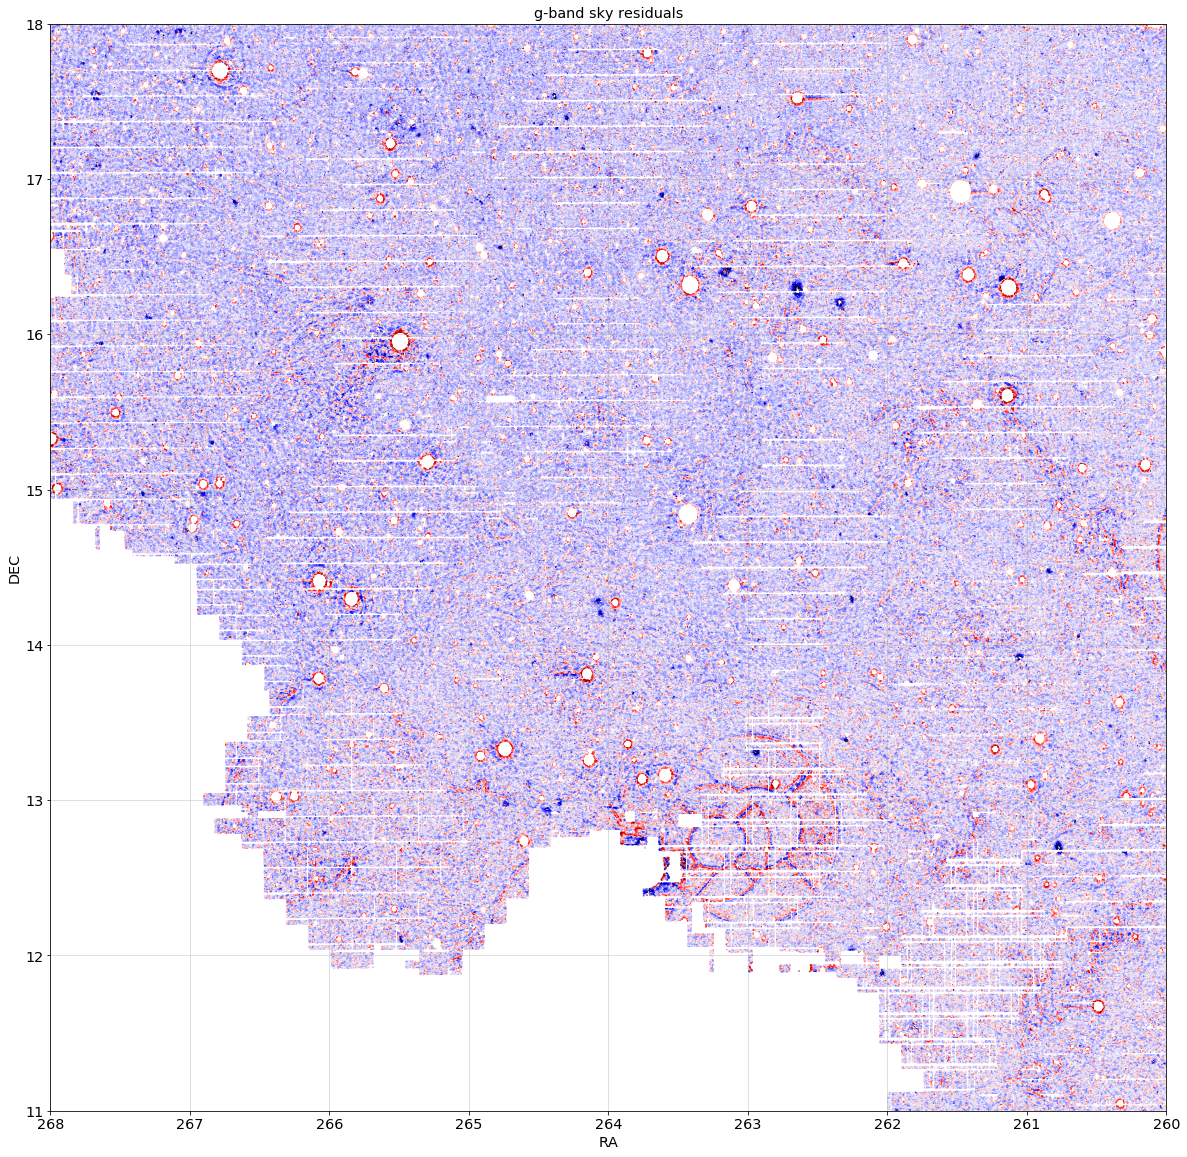

In [10]:
for band in ['g']:
    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.scatter(sweep['RA'][mask_clean][::2], sweep['DEC'][mask_clean][::2], c=sweep[band+'_sky'][mask_clean][::2], vmin=-0.02, vmax=0.02, s=0.2, alpha=1., cmap='seismic')
    ax.axis([ramax, ramin, decmin, decmax])
    ax.grid(alpha=0.5)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    # fig.colorbar(im)
    ax.set_title(band+'-band sky residuals')
    plt.show()

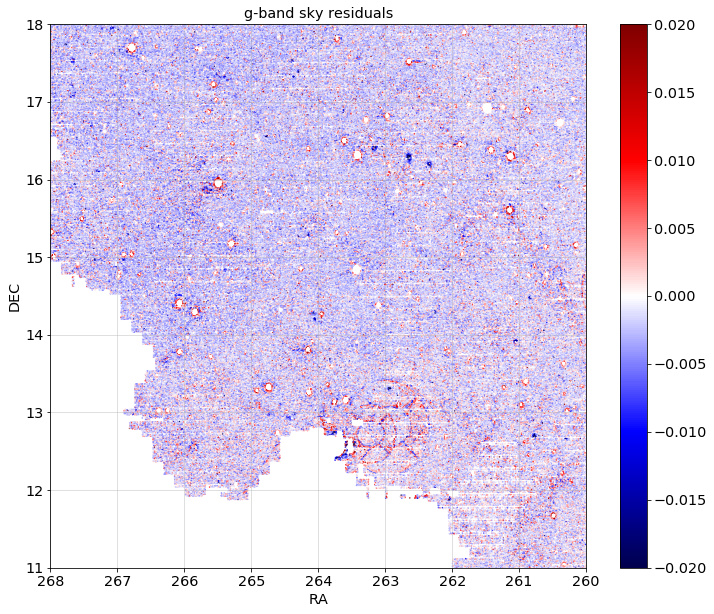

In [6]:
# Smaller version
for band in ['g']:
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.scatter(sweep['RA'][mask_clean][::10], sweep['DEC'][mask_clean][::10], c=sweep[band+'_sky'][mask_clean][::10], vmin=-0.02, vmax=0.02, s=0.2, alpha=1., cmap='seismic')
    ax.axis([ramax, ramin, decmin, decmax])
    ax.grid(alpha=0.5)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    fig.colorbar(im)
    ax.set_title(band+'-band sky residuals')
    plt.show()

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sweep['gmag'] = 22.5 - 2.5*np.log10(sweep['FLUX_G']/sweep['MW_TRANSMISSION_G'])
    sweep['rmag'] = 22.5 - 2.5*np.log10(sweep['FLUX_R']/sweep['MW_TRANSMISSION_R'])
    sweep['zmag'] = 22.5 - 2.5*np.log10(sweep['FLUX_Z']/sweep['MW_TRANSMISSION_Z'])
    sweep['w1mag'] = 22.5 - 2.5*np.log10(sweep['FLUX_W1']/sweep['MW_TRANSMISSION_W1'])
    sweep['w2mag'] = 22.5 - 2.5*np.log10(sweep['FLUX_W2']/sweep['MW_TRANSMISSION_W2'])
    
# Apply ELG selection
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mask_elg = sweep['gmag'] > 20.0
    mask_elg &= sweep['gmag'] < 23.5
    mask_elg &= (sweep['rmag'] - sweep['zmag']) > 0.3
    mask_elg &= sweep['rmag'] - sweep['zmag'] < 1.6
    mask_elg &= sweep['gmag'] - sweep['rmag'] < 1.15 * (sweep['rmag'] - sweep['zmag']) - 0.15
    mask_elg &= sweep['gmag'] - sweep['rmag'] < -1.20 * (sweep['rmag'] - sweep['zmag']) + 1.6
print(np.sum(mask_elg))

82832


sweep objects: median g-band sky residuals per sq arcsec: -0.00138
ELGs: median g-band sky residuals per sq arcsec: -0.00081


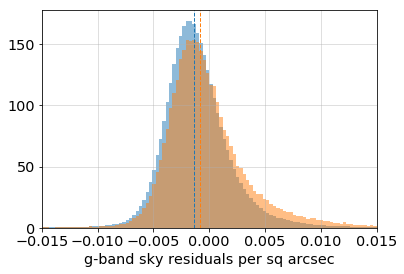

In [12]:
histrange = 0.015
for band in ['g']:
    sweep_g_sky = sweep[band+'_sky'][mask_clean]
    print('sweep objects: median {}-band sky residuals per sq arcsec: {:.5f}'.format(band, np.median(sweep_g_sky)))
    elg_g_sky = sweep[band+'_sky'][mask_clean & mask_elg]
    print('ELGs: median {}-band sky residuals per sq arcsec: {:.5f}'.format(band, np.median(elg_g_sky)))
    plt.hist(sweep_g_sky, 100, range=(-histrange, histrange), density=True, alpha=0.5)
    plt.axvline(np.median(sweep_g_sky), color='C0', ls='--', lw=1)
    plt.hist(elg_g_sky, 100, range=(-histrange, histrange), density=True, alpha=0.5)
    plt.axvline(np.median(elg_g_sky), color='C1', ls='--', lw=1)
    plt.xlim(-histrange, histrange)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'-band sky residuals per sq arcsec')
    plt.show()
print()